# Obtaining dataset

In [1]:
import os
import torch
from torchvision import datasets, models, transforms

## DATA LOADER
data_dir = './images'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# Squeezenet Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    # VAL: transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    # ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)


Loaded 16000 images under train
Loaded 2000 images under test
Classes: 
['flower', 'sugarcane']


# Quantization classes

This implementation is based on the code available at https://github.com/aaron-xichen/pytorch-playground. Although the refered repository offers some options for quantizing popular CNN architectures like Squeezenet, VGG, Alexnet and Resnet, a more dedicated code for my application was necessary in my opinion.

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
import math

def compute_integral_part(input, overflow_rate):
    abs_value = input.abs().view(-1)
    sorted_value = abs_value.sort(dim=0, descending=True)[0]
    split_idx = int(overflow_rate * len(sorted_value))
    v = sorted_value[split_idx]
    if isinstance(v, Variable):
        v = v.data.cpu().numpy()
    sf = math.ceil(math.log2(v+1e-12))
    return sf

def linear_quantize(input, sf, bits):
    assert bits >= 1, bits
    if bits == 1:
        return torch.sign(input) - 1
    delta = math.pow(2.0, -sf)
    bound = math.pow(2.0, bits-1)
    min_val = - bound
    max_val = bound - 1
    rounded = torch.floor(input / delta + 0.5)

    clipped_value = torch.clamp(rounded, min_val, max_val) * delta
    return clipped_value


class LinearQuant(nn.Module):
    def __init__(self, name, bits, sf=None, overflow_rate=0.0, counter=10):
        super(LinearQuant, self).__init__()
        self.name = name
        self._counter = counter

        self.bits = bits
        self.sf = sf
        self.overflow_rate = overflow_rate

    @property
    def counter(self):
        return self._counter

    def forward(self, input):
        if self._counter > 0:
            self._counter -= 1
            sf_new = self.bits - 1 - compute_integral_part(input, self.overflow_rate)
            self.sf = min(self.sf, sf_new) if self.sf is not None else sf_new
            return input
        else:
            output = linear_quantize(input, self.sf, self.bits)
            return output

    def __repr__(self):
        return '{}(sf={}, bits={}, overflow_rate={:.3f}, counter={})'.format(
self.__class__.__name__, self.sf, self.bits, self.overflow_rate, self.counter)


def duplicate_model_with_quant(model, bits, overflow_rate=0.0, counter=10):
    """assume that original model has at least a nn.Sequential"""
    if isinstance(model, nn.Sequential):
        l = OrderedDict()
        for k, v in model._modules.items():
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
                l[k] = v
#                if type == 'linear':
#                    quant_layer = LinearQuant('{}_quant'.format(k), bits=bits, overflow_rate=overflow_rate, counter=counter)
#                elif type == 'log':
#                    # quant_layer = LogQuant('{}_quant'.format(k), bits=bits, overflow_rate=overflow_rate, counter=counter)
#                    quant_layer = NormalQuant('{}_quant'.format(k), bits=bits, quant_func=log_minmax_quantize)
#                elif type == 'minmax':
#                    quant_layer = NormalQuant('{}_quant'.format(k), bits=bits, quant_func=min_max_quantize)
#                else:
#                    quant_layer = NormalQuant('{}_quant'.format(k), bits=bits, quant_func=tanh_quantize)
                quant_layer = LinearQuant('{}_quant'.format(k), bits=bits, overflow_rate=overflow_rate, counter=counter)
                l['{}_{}_quant'.format(k, type)] = quant_layer
            else:
                l[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter)
        m = nn.Sequential(l)
        return m
    else:
        for k, v in model._modules.items():
            model._modules[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter)
    return model

def eval_model(squeezenet, criterion, verbose=False):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    if verbose:
        print("Evaluating model")
        print('-' * 10)

    squeezenet.train(False)
    squeezenet.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[TEST]):
            if verbose:
                if i % 10 == 0:
                    print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)


            inputs, labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels

            outputs = squeezenet(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.data
            acc_test += torch.sum(preds == labels.data).item()

            # del inputs, labels, outputs, preds
            # torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    if verbose:
        print()
        print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print("Avg loss (test): {:.4f}".format(avg_loss))
        print("Avg acc (test): {:.4f}".format(avg_acc))
        print('-' * 10)
    return avg_acc, avg_loss



In [3]:
import argparse
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark =True
from collections import OrderedDict

import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn

#parser = argparse.ArgumentParser(description='PyTorch SVHN Example')
# parser.add_argument('--type', default='cifar10', help='|'.join(selector.known_models))
# parser.add_argument('--quant_method', default='linear', help='linear|minmax|log|tanh')
#parser.add_argument('--batch_size', type=int, default=100, help='input batch size for training (default: 64)')
#parser.add_argument('--gpu', default=None, help='index of gpus to use')
#parser.add_argument('--ngpu', type=int, default=8, help='number of gpus to use')
#parser.add_argument('--seed', type=int, default=117, help='random seed (default: 1)')
# parser.add_argument('--model_root', default='~/.torch/models/', help='folder to save the model')
# parser.add_argument('--data_root', default='/tmp/public_dataset/pytorch/', help='folder to save the model')
# parser.add_argument('--logdir', default='log/default', help='folder to save to the log')

#parser.add_argument('--input_size', type=int, default=224, help='input size of image')
# parser.add_argument('--n_sample', type=int, default=20, help='number of samples to infer the scaling factor')
#parser.add_argument('--param_bits', type=int, default=8, help='bit-width for parameters')
#parser.add_argument('--bn_bits', type=int, default=32, help='bit-width for running mean and std')
#parser.add_argument('--fwd_bits', type=int, default=8, help='bit-width for layer output')
# parser.add_argument('--overflow_rate', type=float, default=0.0, help='overflow rate')
# args = parser.parse_args()

args = {}

args['batch_size'] = 100
args['gpu'] = None
args['ngpu'] = 8
args['seed'] = 117
args['input_size'] = 224
#args['param_bits'] = 2
#args['bn_bits'] = 2
#args['fwd_bits'] = 2
args['overflow_rate'] = 0.0

#args.gpu = misc.auto_select_gpu(utility_bound=0, num_gpu=args.ngpu, selected_gpus=args.gpu)
#args.ngpu = len(args.gpu)
#misc.ensure_dir(args.logdir)
#args.model_root = misc.expand_user(args.model_root)
#args.data_root = misc.expand_user(args.data_root)
#args.input_size = 299 if 'inception' in args.type else args.input_size
#assert args.quant_method in ['linear', 'minmax', 'log', 'tanh']
#print("=================FLAGS==================")
#for k, v in args.__dict__.items():
#    print('{}: {}'.format(k, v))
#print("========================================")

#assert torch.cuda.is_available(), 'no cuda'
torch.manual_seed(args['seed'])
torch.cuda.manual_seed(args['seed'])

use_gpu = torch.cuda.is_available()
# use_gpu = False
if use_gpu:
    print("Using CUDA")

Using CUDA


In [4]:

def create_model():
    # load model and dataset fetcher
    # model_raw, ds_fetcher, is_imagenet = selector.select(args.type, model_root=args.model_root)
    #squeezenet1_1 = models.squeezenet1_1()

    # importing fixed version of squeezenet class and functions
    import squeezenet_fix

    squeezenet1_1 = squeezenet_fix.squeezenet1_1()

    # Freeze training for all layers
    for param in squeezenet1_1.features.parameters():
        param.require_grad = False

    # Newly created modules have require_grad=True by default
    num_features = squeezenet1_1.classifier[1].in_channels
    features = list(squeezenet1_1.classifier.children())[:-3] # Remove last 3 layers
    features.extend([nn.Conv2d(num_features, 2, kernel_size=1)]) # Add
    features.extend([nn.ReLU(inplace=True)]) # Add
    features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add our layer with 2 outputs
    squeezenet1_1.classifier = nn.Sequential(*features) # Replace the model classifier

    squeezenet1_1.load_state_dict(torch.load('./weights/squeezenet_v1-flower-or-crops.pt'))
    #print(squeezenet1_1)
    return squeezenet1_1


In [5]:
def quantize_state_dict(state_dict, bn_bits, param_bits):
    if param_bits < 32:
        state_dict_quant = OrderedDict()
        sf_dict = OrderedDict()
        for k, v in state_dict.items():
            if 'running' in k:
                if bn_bits >=32:
                    print("Ignoring {}".format(k))
                    state_dict_quant[k] = v
                    continue
                else:
                    bits = bn_bits
            else:
                bits = param_bits

    #        if args.quant_method == 'linear':
    #            sf = bits - 1. - quant.compute_integral_part(v, overflow_rate=args.overflow_rate)
    #            v_quant  = quant.linear_quantize(v, sf, bits=bits)
    #        elif args.quant_method == 'log':
    #            v_quant = quant.log_minmax_quantize(v, bits=bits)
    #        elif args.quant_method == 'minmax':
    #            v_quant = quant.min_max_quantize(v, bits=bits)
    #        else:
    #            v_quant = quant.tanh_quantize(v, bits=bits)
            # using uniform affine quantization
    #        layer_max = torch.max(v).item()
    #        layer_min = torch.min(v).item()
            sf = bits - 1. - compute_integral_part(v, overflow_rate=args['overflow_rate'])
            v_quant  = linear_quantize(v, sf, bits=bits)     
            state_dict_quant[k] = v_quant
        return state_dict_quant

In [6]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time


def quantize_model_forward_activation(model, fwd_bits):
    # Quantize the forward activaton of parameters on the model
    if fwd_bits < 32:
        model = duplicate_model_with_quant(model, bits=fwd_bits)
        #print(squeezenet1_1)
        #val_ds_tmp = ds_fetcher(10, data_root=args.data_root, train=False, input_size=args.input_size)
        #misc.eval_model(model_raw, val_ds_tmp, ngpu=1, n_sample=args.n_sample, is_imagenet=is_imagenet)
        if use_gpu:
            model.cuda() #.cuda() will move everything to the GPU side
    return model

In [12]:
bits_list = list(range(1, 32))

test_accuracies_list = []
test_losses_list = []

for idx, bits_item in enumerate(bits_list):
    print("\rRunning Tests {}/{}".format(idx+1, len(bits_list)), end='', flush=True)
    # Quantize weights
    squeezenet1_1 = create_model()
    state_dict = squeezenet1_1.state_dict()
    state_dict_quant = quantize_state_dict(state_dict, bits_item, bits_item)
    #print(state_dict_quant)
    squeezenet1_1.load_state_dict(state_dict_quant)

    # Quantize forward activation
    squeezenet1_1_quant = quantize_model_forward_activation(squeezenet1_1, bits_item)

    # evaluate
    criterion = nn.CrossEntropyLoss()
    #optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    avg_acc, avg_loss = eval_model(squeezenet1_1_quant, criterion)
    test_accuracies_list.append(avg_acc)
    test_losses_list.append(avg_loss)
    
    #print()
    #print(idx)
    #print(bits_item)
    #print(avg_acc)
    #print(test_accuracies_list)


Running Tests 31/31

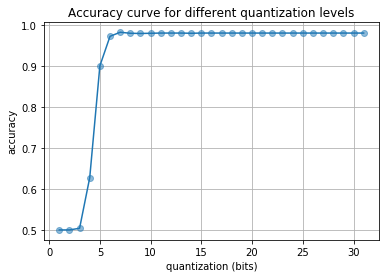

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.array(bits_list)
s = np.array(test_accuracies_list)

fig, ax = plt.subplots()
ax.plot(t, s)
plt.plot(t, s, 'C0o', alpha=0.5)

ax.set(xlabel='quantization (bits)', ylabel='accuracy',
       title='Accuracy curve for different quantization levels')
ax.grid()

fig.savefig("acc_over_bits.png")
plt.show()

In [16]:
#import torch.optim as optim

# eval model
#val_ds = ds_fetcher(args.batch_size, data_root=args.data_root, train=False, input_size=args.input_size)
#acc1, acc5 = misc.eval_model(squeezenet1_1, val_ds, ngpu=args.ngpu, is_imagenet=is_imagenet)

# print sf
#print(squeezenet1_1)
#res_str = "type={}, quant_method={}, param_bits={}, bn_bits={}, fwd_bits={}, overflow_rate={}, acc1={:.4f}, acc5={:.4f}".format(
#    args.type, args.quant_method, args.param_bits, args.bn_bits, args.fwd_bits, args.overflow_rate, acc1, acc5)
#print(res_str)
#with open('acc1_acc5.txt', 'a') as f:
#    f.write(res_str + '\n')